### load predictions from log

In [5]:
# plotting configuration
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

params = {
   'axes.labelsize': 12,
   'text.fontsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   }
mpl.rcParams.update(params)
sns.set_style("whitegrid")
sns.despine()

/home/roseyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [10]:
#06-15-17-17-24-40
#05-17-17-16-17-44
#06-15-17-17-24-40
#08-22-17-00-24-10
#08-30-17-23-53-05
time_stamp ="09-18-17-11-56-02"
exp='lorenz'
models =["LSTM"] #phased_lstm
hz_list= [128]
lr_list =[2]
steps =  [20, 40, 60, 80, 100]


import numpy as np
def read_config(fstream):
    d = {}
    for line in fstream:
        line.rstrip()
        tokens = line.split('\t')
        for token in tokens:
            try:
                key, val = token.split(":")
                d[key] = float(val)                
            except ValueError:
                'error prop'
    return d
def load_log(st, model):
    data_path = "/var/tmp/tensorRNN/log/"+exp+"/"+time_stamp+"/"+model+"/"+"st_"+str(st)+"/"
    f_pred= "predict.npy"
    f_err = "config.out"
    pred =  np.load(data_path+f_pred )
    with open(data_path+"/"+f_err,'r') as fstream:
        config = read_config(fstream)
    return config, pred

def reshape_pred(y):
    y = np.squeeze(y)
    n_dim = np.shape(y)[-1]
    y = np.reshape(y, [-1, n_dim])
#     print('y shape', np.shape(y))
    return y

def get_best_pred(model):
    err_best = 1e6
    i=0
    for model in models:
        j=0
        for st in steps:
#             print('load model {:s}, hidden size {:d}, learning rate 1e-{:d}'.format(model, hz, lr))
            try:
                config, pred = load_log(st, model)
    #             print('train error:',config['train_error'],'valid error:',config['valid_error'],'test err:',config['test_error'])
                err =  config['test_error']
            except FileNotFoundError:
                'log does not exits'
                err = 1e3
            # save the best results so far
            if err < err_best:
                err_best = err
                pred_best = pred     
            j+=1
        i+=1
    y_true, y_pred = pred_best
    y_true = reshape_pred(y_true)
    y_pred = reshape_pred(y_pred)
    return (y_true, y_pred)



pred_rnn = get_best_pred('RNN')
pred_lstm = get_best_pred('LSTM')
pred_mrnn = get_best_pred('MRNN')


### visualize the Lorenz prediction

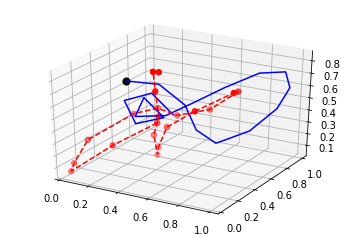

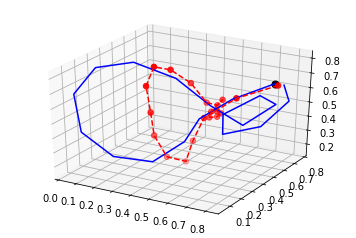

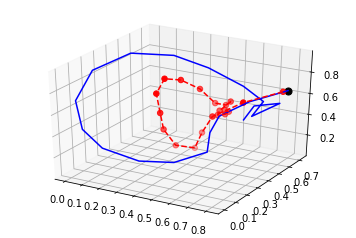

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

data_path= "/var/tmp/tensorRNN/log/lorenz/10-06-17-12-23-21/TLSTM/64/1e-3/"
true, pred = np.load(data_path+'predict.npy')
#remove the EOS
# print(true[0,40:50,:])
# print(pred[0,40:50,:])
true = true[:,40:60,:]
pred = pred[:,40:60,:]

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
    ax.scatter(true[sample_id, 0,0], true[sample_id,0,1], true[sample_id, 0,2], c='k', s=50)

plot_sample(pred, true,1)
plot_sample(pred, true,3)
plot_sample(pred, true,7)
# np.save('../experiments/result/trnn_10_err.npy',test_vals)

### Visualize with delta

In [ ]:
import numpy as np
#10-01-17-18-37-00 


%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

inp_steps = 5
# data_path= "/var/tmp/tensorRNN/log/lorenz/09-29-17-22-36-36/TLSTM/64-1e-3/decay"
data_path= "/var/tmp/tensorRNN/log/lorenz/10-02-17-00-24-54/MLSTM/32/1e-3/"
true, pred = np.load(data_path+'predict.npy')


def recover_orbit(test_outs):
    test_outs_denorm = denormalize_colums(test_outs, stats[ntest:,])
    start_orig = data_orig[ntest:,num_steps,:]
    test_outs_orig = diff_2_orig(test_outs_denorm, start_orig )
    return test_outs_orig


def first_add(dat, init=None):
    res = np.zeros(dat.shape)
    if init is None:
        res[0,:]= dat[0,:]
    else:
        res[0,:]= init
    for i in range(1,dat.shape[0]):
        res[i,:] = dat[i,:]+ res[i-1,:]
    return res

def diff_2_orig(lorenz_diff, inits=None):
    lorenz = np.zeros(lorenz_diff.shape)
    for i in range(lorenz_diff.shape[0]):
        if inits is None:
            lorenz[i,:,:]=first_add(lorenz_diff[i,:,:])
        else:
            lorenz[i,:,:]=first_add(lorenz_diff[i,:,:], inits[i,:])
    return lorenz
    
def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
    ax.scatter(true[sample_id, 0,0], true[sample_id,0,1], true[sample_id, 0,2], c='k', s=50)

    
true = recover_orbit(true)
pred = recover_orbit(pred)

for i in range(10):
    plot_sample(pred[:,:-2,:], true[:,:-2,:],i)

### visualize and evaluate prediction 

In [7]:
import numpy as np

def nd(y_pred, y_true):
    """normalized deviation"""
    t1 = np.sum(abs(y_pred-y_true))/ np.size(y_true)
    t2 = np.sum(abs(y_true))/np.size(y_true)
    return t1/t2
    
def nrmse(y_pred, y_true):
    """normalized RMSE"""
    t1 = np.linalg.norm(y_pred-y_true)**2 / np.size(y_true)
    t2 = np.sum(abs(y_true))/np.size(y_true)
    return np.sqrt(t1) / (t2)

def rmse(y_pred, y_true):
    """RMSE"""
    t1 = np.linalg.norm(y_pred-y_true)**2 / np.size(y_true)
    return np.sqrt(t1)

def eval_forecast(pred):
    y_true, y_pred = pred
#     print('y true shape', y_true.shape, 'y_pred shape', y_pred.shape)


    print('ND', nd(y_pred, y_true))
    print('NRMSE',nrmse(y_pred, y_true))
    print('RMSE', rmse(y_pred, y_true))
    return y_true, y_pred

# eval_forecast(pred_rnn)
# eval_forecast(pred_lstm)
# eval_forecast(pred_mrnn)
# eval_forecast(pred_trnn)
y_true, y_pred = eval_forecast(pred_trnn)

ND 0.376402641859
NRMSE 0.539556852247
RMSE 0.275052472833
